# Building Lexicon - Type A - SemEval 2013 dataset

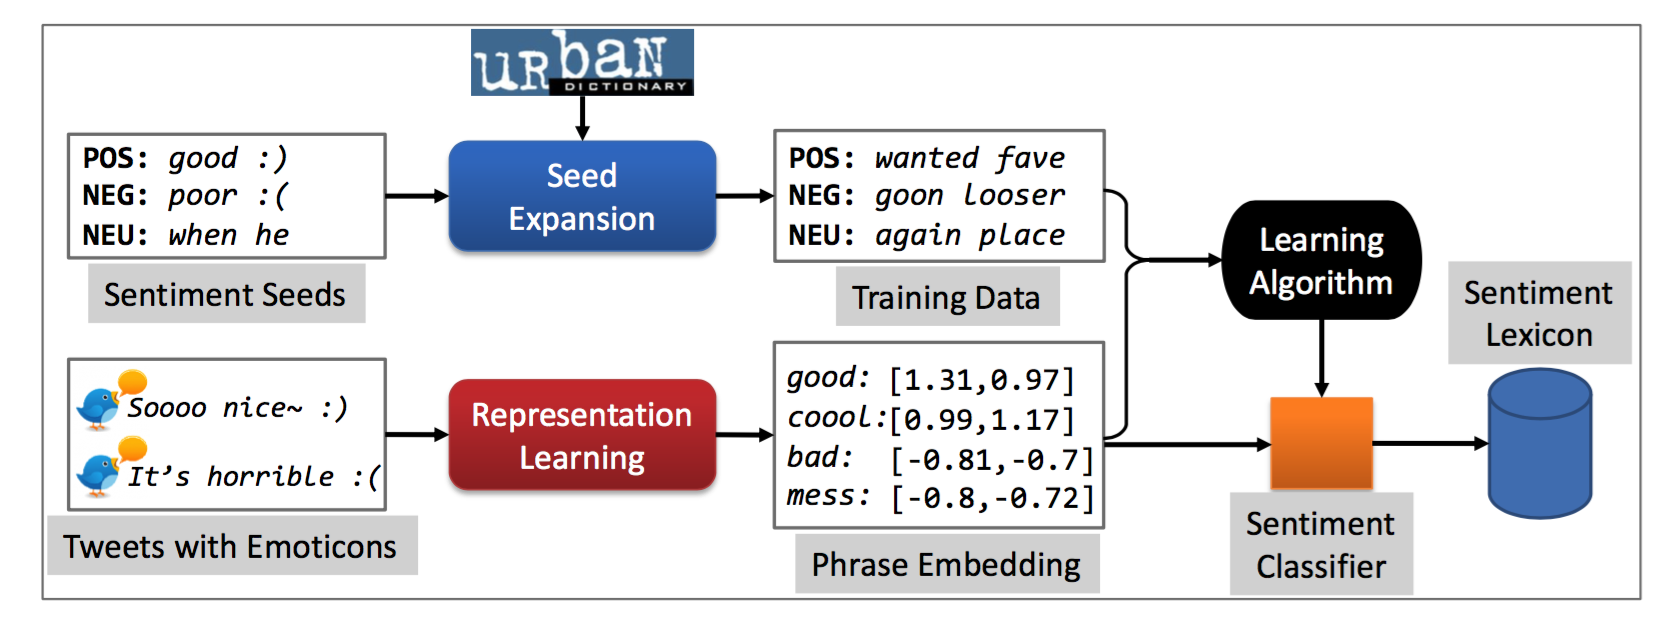

In [183]:
from IPython.display import Image
Image(filename='image.png')

## Step 1 :  Get Word Embeddings using word2vec

In [57]:
import gensim

import zipfile
import collections
filename = 'text8.zip'


import pandas as pd

df = pd.read_csv('/Users/gautamborgohain/CI Submission/Data/SEmEval_train.tsv', sep = '\t',header = None)

df = df[df[3] != 'Not Available']

sens = df[3]
sens = [ [s for s in sen.split()] for sen in sens]
print(len(sens))

def sen_permutation(sens):
    return np.random.permutation(sens)

7554


In [58]:
bigram_transformer = gensim.models.Phrases(sens)
model = gensim.models.Word2Vec(min_count=1,sg = 1, size = 100, alpha =0.025 ,window =3, seed = 1,workers=5)
model.build_vocab(bigram_transformer[sens])

In [59]:
import numpy as np
epoch = 100
for ep in range(epoch):
    model.train(sen_permutation(bigram_transformer[sens]))

In [151]:
import re
vocab = [key for key, val in model.vocab.items() if not re.search(r'[#$@:-_!/]',key)]
f = open('/Users/gautamborgohain/PycharmProjects/MOSCATO/vocab_sem_eval.txt','w')
for word in vocab:
    f.write(word +'\n')
f.close()

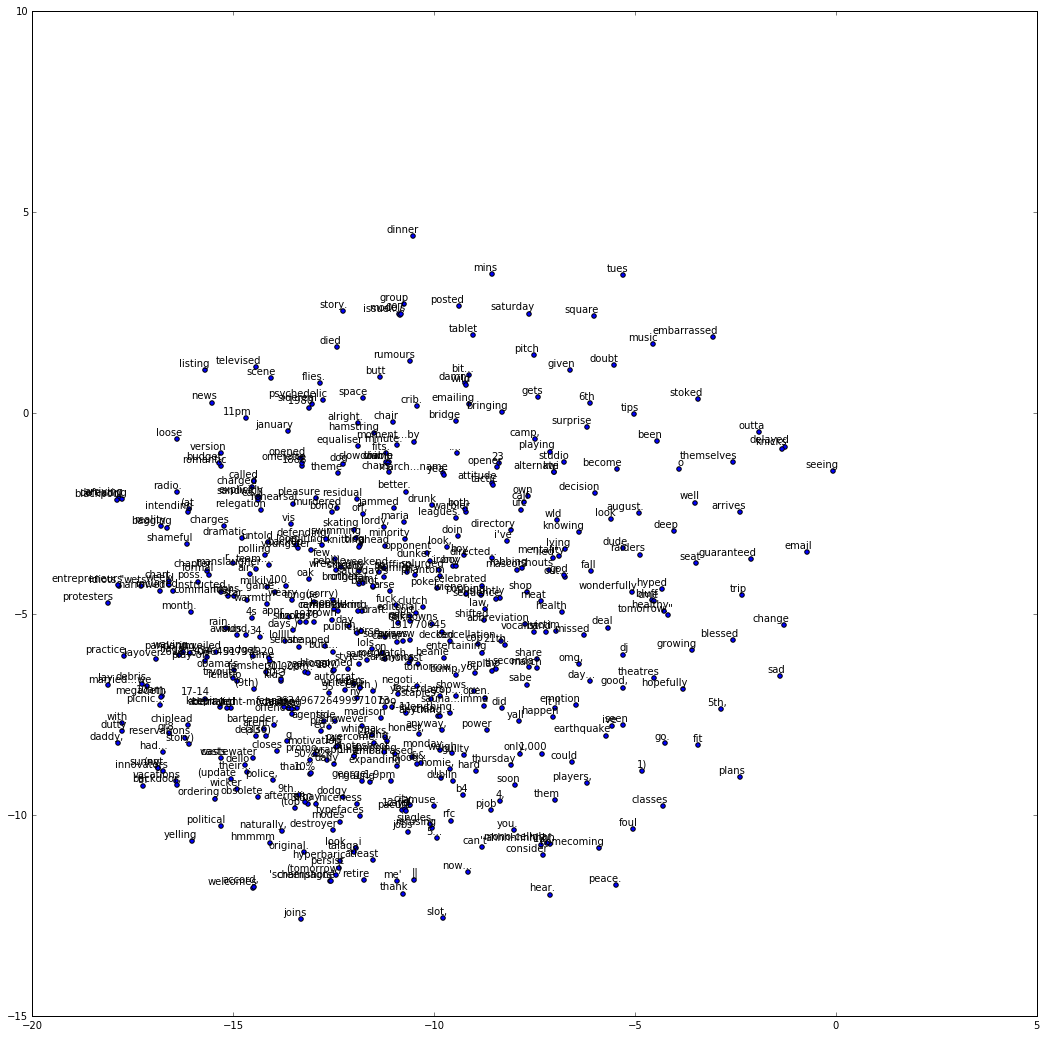

In [61]:
%matplotlib inline

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(learning_rate = 300, init='pca', n_iter=5000)
    plot_only = 500
    labels = vocab[:plot_only]
    low_dim_embs = tsne.fit_transform(model[labels])
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn and matplotlib to visualize embeddings.")


## Step 2  - Get the polarity of the some words

In [54]:
import re
from nltk import word_tokenize
HL_posLoc = '/Users/gautamborgohain/PycharmProjects/DT_Labs/PLayground/Gautam_Borg/HuLiuLexicon/positive-words.txt'
HL_negLoc = '/Users/gautamborgohain/PycharmProjects/DT_Labs/PLayground/Gautam_Borg/HuLiuLexicon/negative-words.txt'

poshand = open(HL_posLoc)
neghand = open(HL_negLoc)
poslist = [re.sub(r'\n','',line) for line in poshand]
neglist = [re.sub(r'\n','',line) for line in neghand]

print(len(poslist),len(neglist))

2006 4783


## Step 3 - Match the embeddings to the polarities

In [62]:

words_in_vocab = []
polarity = []
for pos in poslist:
    if pos in vocab:
        words_in_vocab.append(pos)
        polarity.append(1)
for neg in neglist:
    if neg in vocab:
        words_in_vocab.append(neg)
        polarity.append(0)
        
embeddings = [model[word] for word in words_in_vocab]
print(len(words_in_vocab), len(polarity), len(embeddings))

946 946 946


There are 946 words in the vocabulary for which we have the polarity

In [63]:
training_df = pd.DataFrame({'Word' : words_in_vocab,'Embeddings' : embeddings, 'Polarity':polarity})
training_df.head()

,Embeddings,Polarity,Word
0,"[0.54433, -0.0734173, -0.285509, 0.13175, -0.5...",1,accomplished
1,"[-0.273972, 0.572201, -0.218797, 0.191723, 0.6...",1,achievement
2,"[0.445623, 0.133735, 0.155194, 0.237829, 0.431...",1,admire
3,"[0.263048, -0.158059, 0.420304, 0.617253, -0.2...",1,adorable
4,"[0.0734464, 0.762129, 0.576536, 0.449066, -0.4...",1,adore


In [65]:
training_df.to_pickle('/Users/gautamborgohain/Desktop/train.pck')
model.save('/Users/gautamborgohain/Desktop/semeval_embeds.model')

In [1]:
import pandas as pd
training_df = pd.read_pickle('/Users/gautamborgohain/Desktop/train.pck')
import gensim
model = gensim.models.Word2Vec.load('/Users/gautamborgohain/Desktop/semeval_embeds.model')

# Step 4  - Train a softmax classifier on this data

In [2]:
import tensorflow as tf

size = len(training_df.Embeddings[0])

sess = tf.InteractiveSession()

# Create the model
x = tf.placeholder(tf.float32, [None,size])
W = tf.Variable(tf.zeros([size, 2]))
b = tf.Variable(tf.zeros([2]))
y = tf.nn.softmax(tf.matmul(x, W) + b)

y_ = tf.placeholder(tf.float32, [None, 2])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.AdagradOptimizer(0.5).minimize(cross_entropy)

# Train
tf.initialize_all_variables().run()

In [3]:
X = [x for x in training_df.Embeddings]
Y = [[1 if y == 1 else 0,1 if y == 0 else 0] for y in training_df.Polarity]

In [9]:
epoch = 1000
for ep in range(epoch):
    train_step.run({x: X, y_: Y})
    
predictions = tf.Print(y,[y])
probs = predictions.eval({x:X})

In [10]:
training_df['POS_SCORE'] = [out[0] for out in probs]
training_df['NEG_SCORE'] = [out[1] for out in probs]
training_df['LEX'] =[1 if row.POS_SCORE > row.NEG_SCORE else 0 for index, row in training_df.iterrows()]

In [11]:
training_df.LEX.value_counts()
    

0    653
1    293
Name: LEX, dtype: int64

In [12]:
training_df[0:10]

,Embeddings,Polarity,Word,POS_SCORE,NEG_SCORE,LEX
0,"[0.54433, -0.0734173, -0.285509, 0.13175, -0.5...",1,accomplished,0.475088,0.524912,0
1,"[-0.273972, 0.572201, -0.218797, 0.191723, 0.6...",1,achievement,0.862149,0.137851,1
2,"[0.445623, 0.133735, 0.155194, 0.237829, 0.431...",1,admire,0.663809,0.336191,1
3,"[0.263048, -0.158059, 0.420304, 0.617253, -0.2...",1,adorable,0.400706,0.599294,0
4,"[0.0734464, 0.762129, 0.576536, 0.449066, -0.4...",1,adore,0.278218,0.721782,0
5,"[0.341876, 0.781855, 0.964716, -0.128742, -0.0...",1,advanced,0.406148,0.593852,0
6,"[-0.0618483, 1.07416, 0.184691, 0.510679, -0.5...",1,advocates,0.720183,0.279817,1
7,"[-0.480007, 0.0352463, -0.0771753, 0.480468, -...",1,affectionate,0.286147,0.713853,0
8,"[0.114349, 0.0611302, 0.208228, 0.833539, -0.7...",1,afford,0.549392,0.450608,1
9,"[0.481504, 0.639928, 0.118733, -0.137362, 0.30...",1,affordable,0.714125,0.285875,1


*Same process but with a SVM classifier - the results not tested however*

In [13]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(training_df.Polarity,training_df.LEX))
print(classification_report(training_df.Polarity,training_df.LEX))
print(pd.crosstab(training_df.Polarity, training_df.LEX))

0.693446088795
             precision    recall  f1-score   support

          0       0.70      0.83      0.76       553
          1       0.68      0.50      0.58       393

avg / total       0.69      0.69      0.68       946

LEX         0    1
Polarity          
0         458   95
1         195  198


In [14]:
training_df.Polarity.value_counts()

0    553
1    393
Name: Polarity, dtype: int64

In [15]:
from sklearn.svm import SVC

clf = SVC(kernel='linear',probability=True)
clf.fit(X,training_df.Polarity)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [16]:
clf.score(X,training_df.Polarity)

0.70613107822410148

In [18]:
preds = clf.predict_proba(X)
training_df['SVM_POS_SCORE'] = [pred[1] for pred in preds ]
training_df['SVM_NEG_SCORE'] = [pred[0] for pred in preds ]
training_df['SVM_LEX'] =[1 if row.SVM_POS_SCORE > row.SVM_NEG_SCORE else 0 for index, row in training_df.iterrows()]

# Step 5 Use the classifier to get the polarity of the rest of the words based on the embeddings

In [19]:
import re
vocab = [key for key, val in model.vocab.items() if not re.search(r'[#$@:-_!/]',key)]


In [20]:
X = [model[word] for word in vocab]


In [21]:
predictions = tf.Print(y,[y])
probs_1 = predictions.eval({x:X})

In [22]:
probs_2 = clf.predict_proba(X)

In [23]:
probs_2[0:10]

array([[ 0.6181555 ,  0.3818445 ],
       [ 0.62069274,  0.37930726],
       [ 0.60775263,  0.39224737],
       [ 0.59490651,  0.40509349],
       [ 0.6118767 ,  0.3881233 ],
       [ 0.62870949,  0.37129051],
       [ 0.63328774,  0.36671226],
       [ 0.58679874,  0.41320126],
       [ 0.63148288,  0.36851712],
       [ 0.6429719 ,  0.3570281 ]])

# Step 6 -  Save the predictions as Lexicons

In [25]:
lex_dict = dict()
for word,index in zip(vocab,range(len(vocab))):
    lex_dict[word] = probs_1[index]
pos_lex = []
neg_lex = []
for key,val in lex_dict.items():
    if val[0] > val[1]:
        pos_lex.append(key)
    else:
        neg_lex.append(key)
    
pos_lex.sort()
neg_lex.sort()

In [26]:
f = open('/Users/gautamborgohain/Desktop/pos_lex.txt', mode = 'w')
for word in pos_lex:
    f.writelines(str(word + '\t' + str(lex_dict[word]) + '\n'))
f.close()
f = open('/Users/gautamborgohain/Desktop/neg_lex.txt', mode = 'w')
for word in neg_lex:
    f.writelines(str(word + '\t' + str(lex_dict[word]) + '\n'))
f.close()


### Lexicon stats

In [133]:
print('POSITIVE :', len(pos_lex))
print('NEGATIVE :', len(neg_lex))

only_words_pos = [word for word in pos_lex if re.match(r'^[a-z]+$',word)]
only_words_neg = [word for word in neg_lex if re.match(r'^[a-z]+$',word)]

print('POSITVE_WORDS :', len(only_words_pos))
print('NEGATIVE_WORDS :', len(only_words_neg))

POSITIVE : 3405
NEGATIVE : 8615
POSITVE_WORDS : 2220
NEGATIVE_WORDS : 4979


*Read*

In [53]:
f = open('/Users/gautamborgohain/Desktop/pos_lex.txt', mode = 'r')
pos_lex = [re.sub(r'\n','',word) for word in f.readlines()]
f.close()
f = open('/Users/gautamborgohain/Desktop/neg_lex.txt', mode = 'r')
neg_lex = [re.sub(r'\n','',word) for word in f.readlines()]
f.close()

# Step 7 - Try out the lexicon on the test dataset

In [27]:
test = pd.read_excel('/Users/gautamborgohain/CI Submission/Data/SemEval Test.xlsx')
test = test[test.Tweet != 'Not Available']
print(len(test))
print(test.Sentiment.value_counts())
test.head()

7849
neutral     3548
positive    2970
negative    1331
Name: Sentiment, dtype: int64


,ID,USER ID,Sentiment,Tweet,Unnamed: 4
1,282031301962395008,T14111200,neutral,dec 21st 2012 will be know not as the end of t...,NaN
2,11975,SM112166,negative,Yar he quite clever but aft many guesses lor. ...,Yes.
3,136592,LJ112295,negative,Yeah we have Thin Lizzy here I HATE the inform...,Not Available
4,253421252956544992,T13114433,neutral,"MT @LccSy #Syria, Deir Ezzor: Ali Bashar al-th...",NaN
5,220880422320603008,T14114138,negative,"@MacMiller hate my life, because i can't see y...",NaN


In [50]:
sentiment_dict = {'positive':1,'negative':-1,'neutral':0}
test.replace({'Sentiment':sentiment_dict}, inplace= True)


### Unsupervised classification

- Read lexicon for each token: for word w -> [p(pos), p(neg)]
- Get the polarity if coparing the pos and the neg scores
    - if p(pos) - p(neg) > 3 ; *Positive*
    - if p(pos) - p(neg) between -3,3 ; *Neutral*
    - if p(pos) - p(neg) < -3; *Negative*

In [134]:
from nltk import word_tokenize
import numpy as np
temp = 'Yeah we have Thin Lizzy here I HATE the inform'
predictions = []

for tweet in test.Tweet:
    sent_score = [0,0]
    for token in word_tokenize(tweet):
        token = token.lower()
        try:
            vals = lex_dict[token]
            sent_score = np.add(sent_score,vals)
        except Exception as e :
            vals = [0,0]#Do nothing?
    predictions.append(sent_score)



In [135]:
window = 3.0
polarity = [1 if preds[0] - preds [1] >= window else 0 if 0 <= abs(preds[0] - preds[1]) < window else -1 for preds in predictions]
test['Predictions'] = polarity
test.head()

,ID,USER ID,Sentiment,Tweet,Unnamed: 4,Predictions
1,282031301962395008,T14111200,0,dec 21st 2012 will be know not as the end of t...,NaN,-1
2,11975,SM112166,-1,Yar he quite clever but aft many guesses lor. ...,Yes.,0
3,136592,LJ112295,-1,Yeah we have Thin Lizzy here I HATE the inform...,Not Available,0
4,253421252956544992,T13114433,0,"MT @LccSy #Syria, Deir Ezzor: Ali Bashar al-th...",NaN,-1
5,220880422320603008,T14114138,-1,"@MacMiller hate my life, because i can't see y...",NaN,0


In [136]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(test.Sentiment,test.Predictions))
print(classification_report(test.Sentiment,test.Predictions))
print(pd.crosstab(test.Sentiment,test.Predictions))

0.444770034399
             precision    recall  f1-score   support

         -1       0.27      0.17      0.21      1331
          0       0.46      0.88      0.61      3548
          1       0.57      0.05      0.09      2970

avg / total       0.47      0.44      0.34      7849

Predictions   -1     0    1
Sentiment                  
-1           230  1081   20
 0           345  3113   90
 1           282  2540  148


Normalizing the prediction and only comparing positive and negative classes

In [137]:
def normalize(lst):
    s = sum(lst)
    return  [i/s for i in lst]

norm_preds = normalize(predictions)

polarity = [1 if preds[0] - preds [1] > 0  else -1 for preds in norm_preds]

test['Predictions'] = polarity

test_temp = test[test.Sentiment != 0]
print(accuracy_score(test_temp.Sentiment,test_temp.Predictions))
print(classification_report(test_temp.Sentiment,test_temp.Predictions))
print(pd.crosstab(test_temp.Sentiment,test_temp.Predictions))

0.577540106952
             precision    recall  f1-score   support

         -1       0.38      0.60      0.47      1331
          1       0.76      0.57      0.65      2970

avg / total       0.64      0.58      0.59      4301

Predictions    -1     1
Sentiment              
-1            801   530
 1           1287  1683


### Supervised - SVM 

**Features prepared :**

 - Sum of the positive and negative probabilities of each word
 - Positive/Negative/Neutral classification based explained earlier
 
 **+**
 
 *Sentiment features of Mohammed et al, 2013*
 
 
 - total count of tokens in the tweet with score greater than 0; 
 - the sum of the scores for all tokens in the tweet;
 - the maximal score;
 - the non-zero score of the last token in the tweet;

In [166]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk import word_tokenize

class lexicon_feats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, frame):
        predictions = []
        for tweet in frame:
            sent_score = [0,0]
            scores = []
            max_pos_score = 0
            max_neg_score = 0
            for token in word_tokenize(tweet):
                token = token.lower()
                try:
                    vals = lex_dict[token]
                    sent_score = np.add(sent_score,vals)
                    scores.append(vals)
                    if abs(val[0]) > max_pos_score:
                        max_pos_score = val[0]
                    if abs(val[1]) > max_neg_score:
                        max_neg_score = val[1]
                except Exception as e :
                    vals = [0,0]#Do nothing- can use dict get method instead of try catch
            sent_score = np.append(sent_score , 1 if sent_score[0] - sent_score [1] >= 3.0 else 0 if 0 <= abs(sent_score[0] - sent_score[1]) < 3.0 else -1)
            #Total count of positve and negative words
            pos_count = len([1 for score in scores if score[0]>score[1]])
            neg_count = len([1 for score in scores if score[0]<score[1]])
            #Last word score
            last_word_score = scores[-1] if(len(scores)> 0) else [0,0]
            sent_score = np.append(sent_score,[pos_count,neg_count,max_pos_score,max_neg_score, last_word_score[0],last_word_score[1]])
            predictions.append(sent_score)
        return np.matrix(predictions)

### Example of the features created

In [160]:
tweet = ['I am not awesome enough to go to the concert','This is good']
def temp(frame):
    predictions = []
    for tweet in frame:
        sent_score = [0,0]
        scores = []
        max_pos_score = 0
        max_neg_score = 0
        for token in word_tokenize(tweet):
            token = token.lower()
            try:
                vals = lex_dict[token]
                sent_score = np.add(sent_score,vals)
                scores.append(vals)
                if abs(val[0]) > max_pos_score:
                    max_pos_score = val[0]
                if abs(val[1]) > max_neg_score:
                    max_neg_score = val[1]
            except Exception as e :
                vals = [0,0]#Do nothing- can use dict get method instead of try catch
        sent_score = np.append(sent_score , 1 if sent_score[0] - sent_score [1] >= 3.0 else 0 if 0 <= abs(sent_score[0] - sent_score[1]) < 3.0 else -1)
        #Total count of positve and negative words
        pos_count = len([1 for score in scores if score[0]>score[1]])
        neg_count = len([1 for score in scores if score[0]<score[1]])
        #Last word score
        last_word_score = scores[-1]
        sent_score = np.append(sent_score,[pos_count,neg_count,max_pos_score,max_neg_score, last_word_score[0],last_word_score[1]])
        predictions.append(sent_score)
    return np.matrix(predictions)

temp(tweet)

matrix([[ 5.28292572,  4.71707424,  0.        ,  5.        ,  5.        ,
          0.62145984,  0.37854016,  0.31335619,  0.68664384],
        [ 2.08031237,  0.91968779,  0.        ,  2.        ,  1.        ,
          0.62145984,  0.37854016,  0.83178532,  0.16821472]])

Prepareing training data

In [100]:
import pandas as pd
df = pd.read_csv('/Users/gautamborgohain/CI Submission/Data/SEmEval_train.tsv', sep = '\t',header = None)

df = df[df[3] != 'Not Available']
sentiment_dict = {'positive':1,'negative':-1,'neutral':0}
df.replace({2:sentiment_dict}, inplace= True)

df.head()

,0,1,2,3
0,264183816548130816,15140428,1,Gas by my house hit $3.39!!!! I'm going to Cha...
3,264249301910310912,18516728,-1,Iranian general says Israel's Iron Dome can't ...
6,264105751826538497,147088367,1,with J Davlar 11th. Main rivals are team Polan...
7,264094586689953794,332474633,-1,"Talking about ACT's &amp;&amp; SAT's, deciding..."
9,254941790757601280,557103111,-1,"They may have a SuperBowl in Dallas, but Dalla..."


In [103]:
X = df[3]
y = [int(y) for y in df[2]]
Xt = test.Tweet
yt = test.Sentiment

Baseline

In [104]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve, classification_report

pipeline = Pipeline([
    ('features', FeatureUnion([
                    ('bow', CountVectorizer(stop_words='english',lowercase=True))
                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 
print(classification_report(yt,predictions))
print(f1_score(predictions,yt,average='macro', labels = [1,-1]))

0.622372276723
             precision    recall  f1-score   support

         -1       0.54      0.34      0.41      1331
          0       0.62      0.73      0.67      3548
          1       0.65      0.62      0.63      2970

avg / total       0.62      0.62      0.61      7849

0.522893453816


With Lexicon

In [167]:
pipeline = Pipeline([
    ('features', FeatureUnion([
                    ('bow', CountVectorizer(stop_words='english',lowercase=True)),
                    ('lex', lexicon_feats())
                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 
print(classification_report(yt,predictions))
print(f1_score(predictions,yt,average='macro', labels = [1,-1]))

0.627213657791
             precision    recall  f1-score   support

         -1       0.56      0.33      0.42      1331
          0       0.62      0.74      0.68      3548
          1       0.66      0.62      0.64      2970

avg / total       0.62      0.63      0.62      7849

0.52716445034
